# Udacity CarND Vehicle Detection Project
### The goals / steps of this project are the following:

Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
Estimate a bounding box for vehicles detected.

### Step 1: Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

In [1]:
# Import all needed packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import time
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from moviepy.editor import VideoFileClip

%matplotlib inline

In [2]:
#Loading Training data
car_images = glob.glob('./vehicles/**/*.png')
noncar_images = glob.glob('./non-vehicles/**/*.png')

print("Total Car Images: ", len(car_images))
print("Total Non-car Images: ", len(noncar_images))

Total Car Images:  8792
Total Non-car Images:  8968


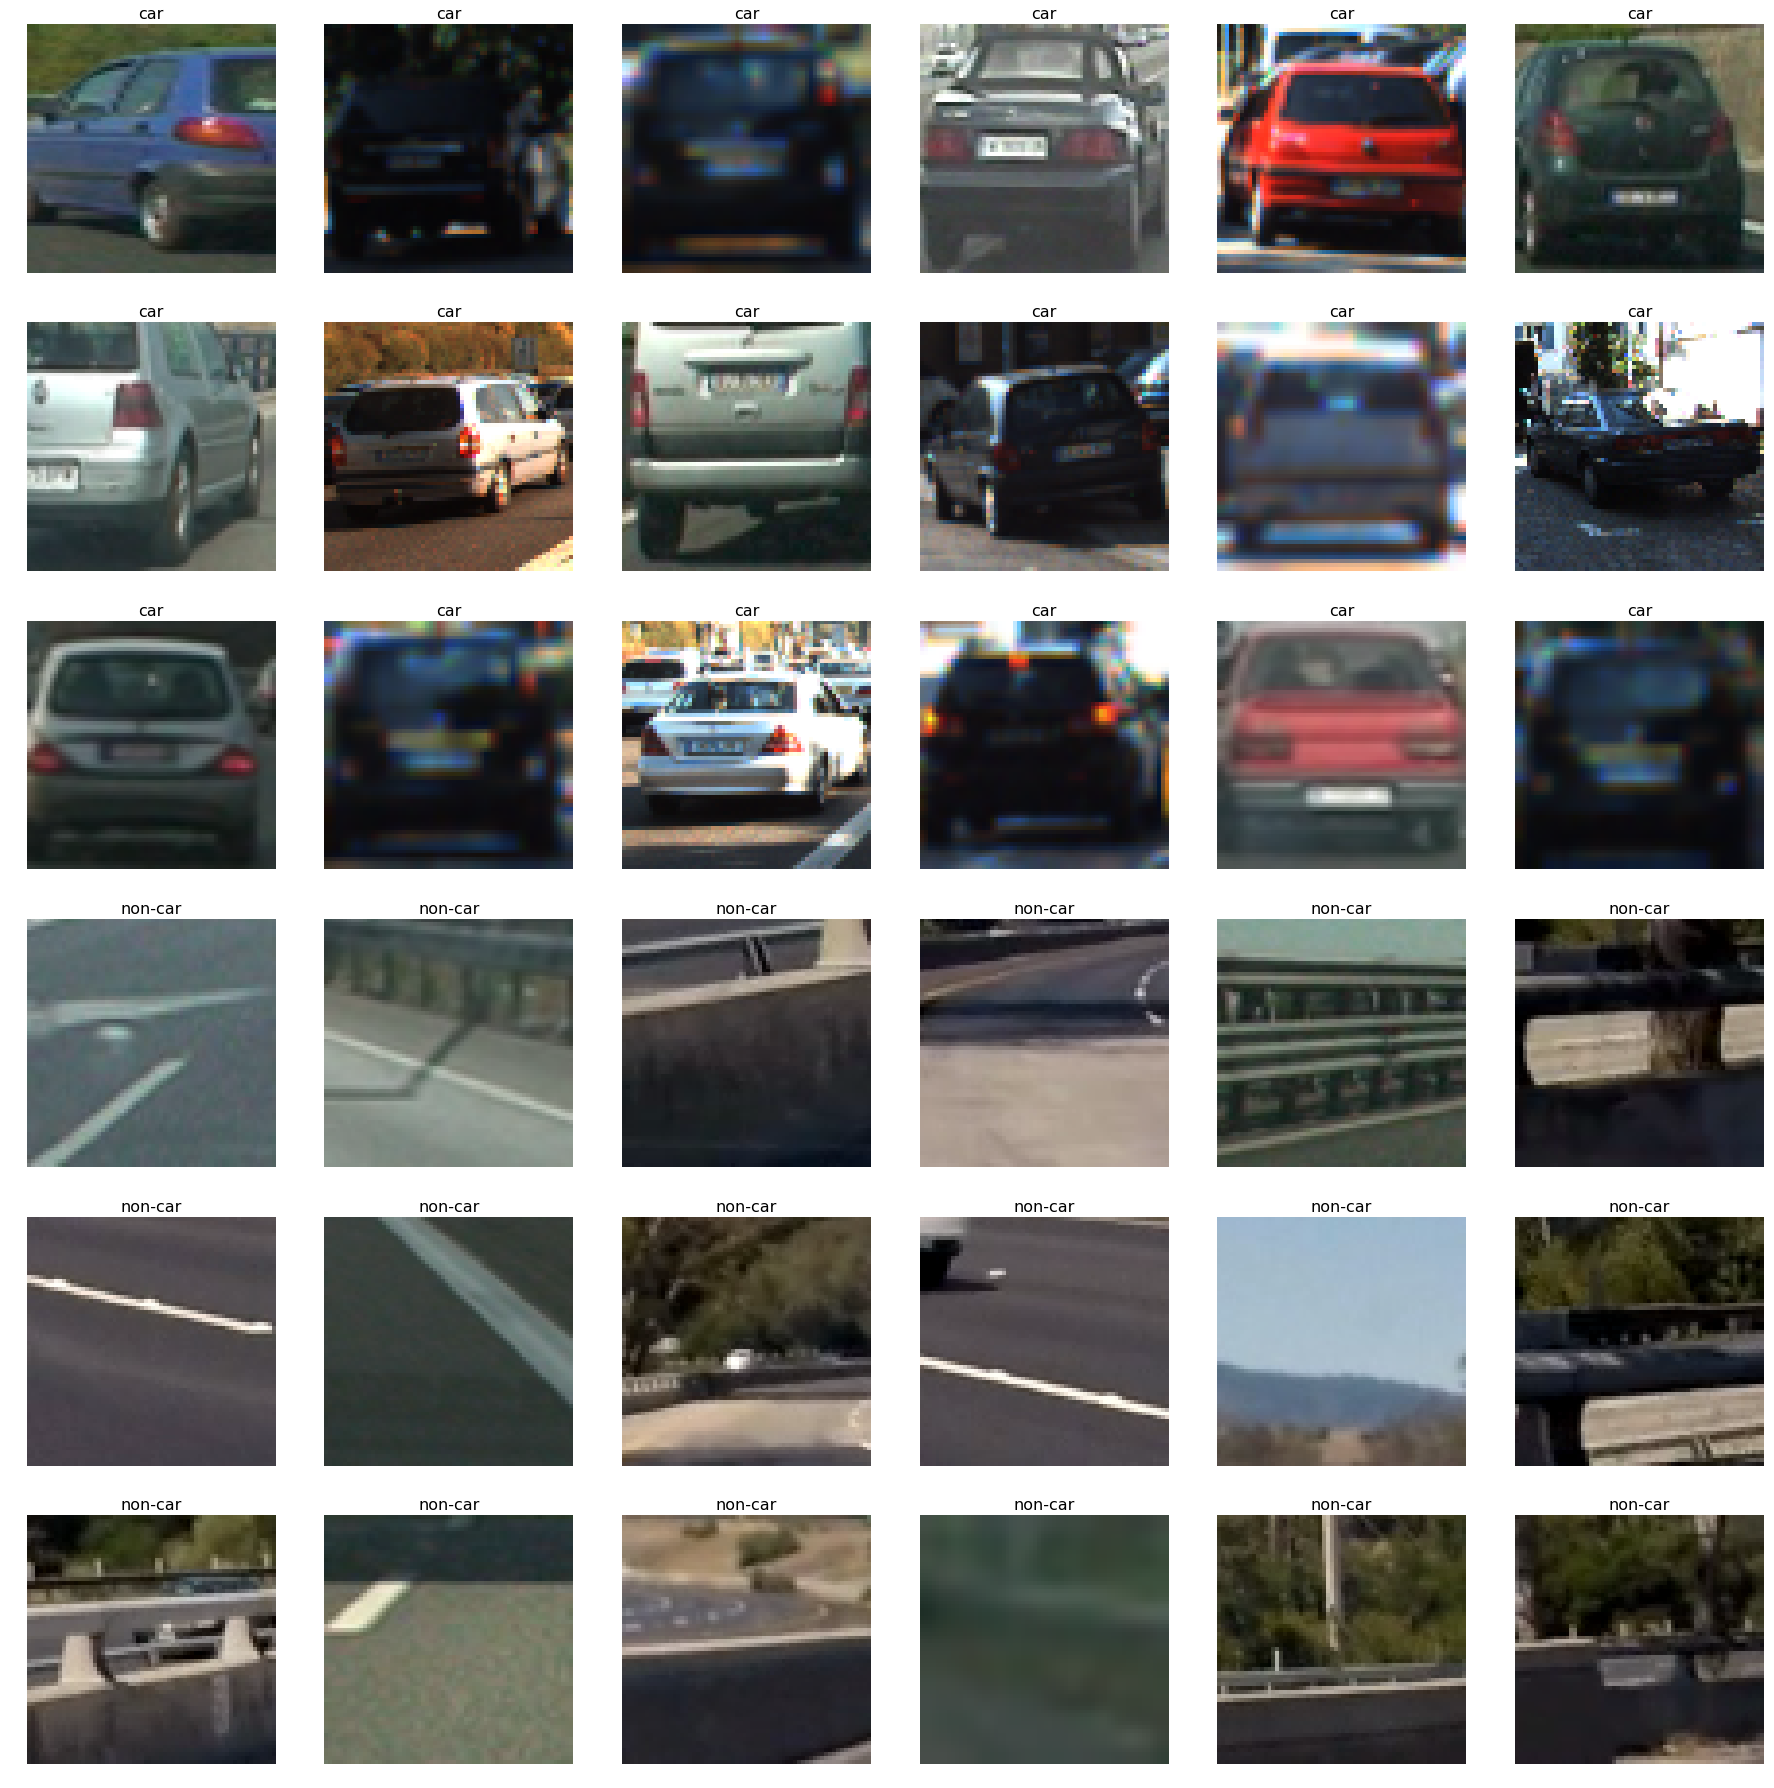

In [3]:
# visualizing some random images （car and non-car)


fig, axs = plt.subplots(6, 6, figsize = (32, 32))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in np.arange(18):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=16)
    axs[i].imshow(img)
for i in np.arange(18,36):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('non-car', fontsize=16)
    axs[i].imshow(img)


In [4]:
# Define HOG Function for converting Image to Histohram of Oriented Gradients (HOG)
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

#### Visualizing HOG on random images

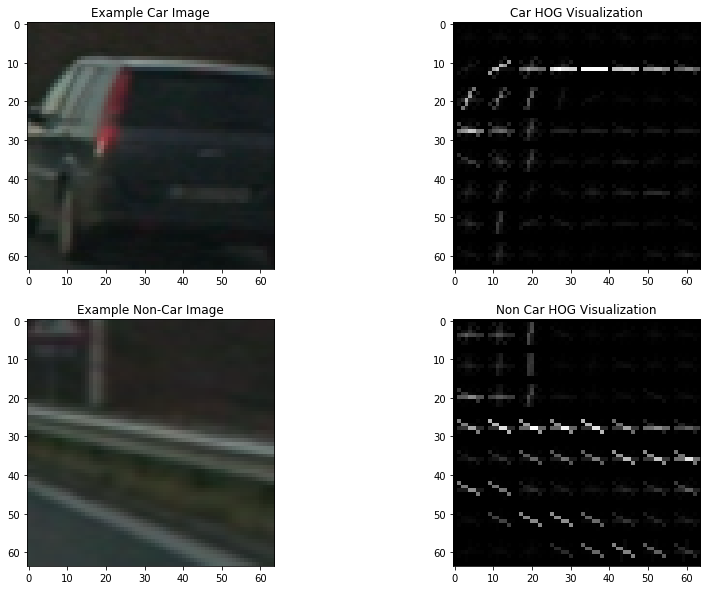

In [5]:
car_img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
car_img = cv2.cvtColor(car_img,cv2.COLOR_BGR2RGB)
car_features, car_hog_img = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

noncar_img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
noncar_img = cv2.cvtColor(noncar_img,cv2.COLOR_BGR2RGB)
noncar_features, noncar_hog_img = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)


fig = plt.figure(figsize=(14, 10))
plt.subplot(221)
plt.imshow(car_img, cmap='gray')
plt.title('Example Car Image')
plt.subplot(222)
plt.imshow(car_hog_img, cmap='gray')
plt.title('Car HOG Visualization')
  
plt.subplot(223)
plt.imshow(noncar_img, cmap='gray')
plt.title('Example Non-Car Image')
plt.subplot(224)
plt.imshow(noncar_hog_img, cmap='gray')
plt.title('Non Car HOG Visualization')

### Define Function to extract HOG features from both Car and Non-Car images

To extract both flattened spatial color and color histogram features, combined both features through using the standardscaler

In [6]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=11, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

#### Getting data features from the training set images

In [7]:
# Feature Extractoin attributes
color_space = 'YCrCb' # Color Space RGB, HSV, LUV, HLS, YUV, YCrCb
spatial = 16
histbin = 32
hog_chan = 'ALL' # Can be 0, 1, 2, or "ALL"

t1=time.time()
# Vehicles features
car_features = extract_features(car_images, color_space=color_space, spatial_size=(spatial, spatial), 
                                hist_bins=histbin,
                                hog_channel=hog_chan)
# Non-vehicles features
notcar_features = extract_features(noncar_images, color_space=color_space, spatial_size=(spatial, spatial), 
                                   hist_bins=histbin, 
                                   hog_channel=hog_chan)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to get features...')


# Create an array stack of feature vectors# Create 
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler only on the training data
#X_scaler = StandardScaler().fit(X_train)
X_scaler = RobustScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using spatial binning of:',spatial, 'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))


130.83 Seconds to get features...
Using spatial binning of: 16 and 32 histogram bins
Feature vector length: 7332


### Training Classifier

In [8]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t1 = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t1=time.time()
n_predict = 10
print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t1, 5), 'Seconds to predict', n_predict,'labels with SVC')

17.63 Seconds to train SVC...
Test Accuracy of SVC =  0.9941
My SVC predicts:      [ 1.  1.  1.  1.  1.  1.  0.  0.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  1.  0.  0.  0.  1.]
0.00928 Seconds to predict 10 labels with SVC


### Using Classifier to detect cars in the images

In [9]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space='YCrCb', orient=9, pix_per_cell=8, 
              cell_per_block=2, spatial_size=(32,32), hist_bins=32, cells_per_step=2):
              # hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):
    
    boxes = []
    draw_img = np.copy(img)
    # Because using png images for the fitting and predict jpg image
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)    
    
    # ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    #cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
           
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left,ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))) 
                
    return boxes
    
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(255, 0, 0), thick=4):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def add_heat(heatmap, bbox_list):
    # Makes a copy of image with all values equal to 0
    heatmap=np.zeros_like(heatmap[:,:,0])
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap1 = np.copy(heatmap)
    # Zero out pixels below the threshold
    heatmap1[heatmap1 <= threshold] = 0
    # Return thresholded map
    return heatmap1

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return img

In [10]:
# Postion vectors
ystarts = [410, 400, 400]
ystops = [480, 550, 620]
# Scale vector
scales = [0.8, 1.5, 2]
cps = [1, 2, 2]  #cells_per_step
color_space='YCrCb'
# Color hist and HOG parameters
orient = 11
pix_per_cell = 8
cell_per_block = 2
spatial_size = (16, 16)
hist_bins = 32

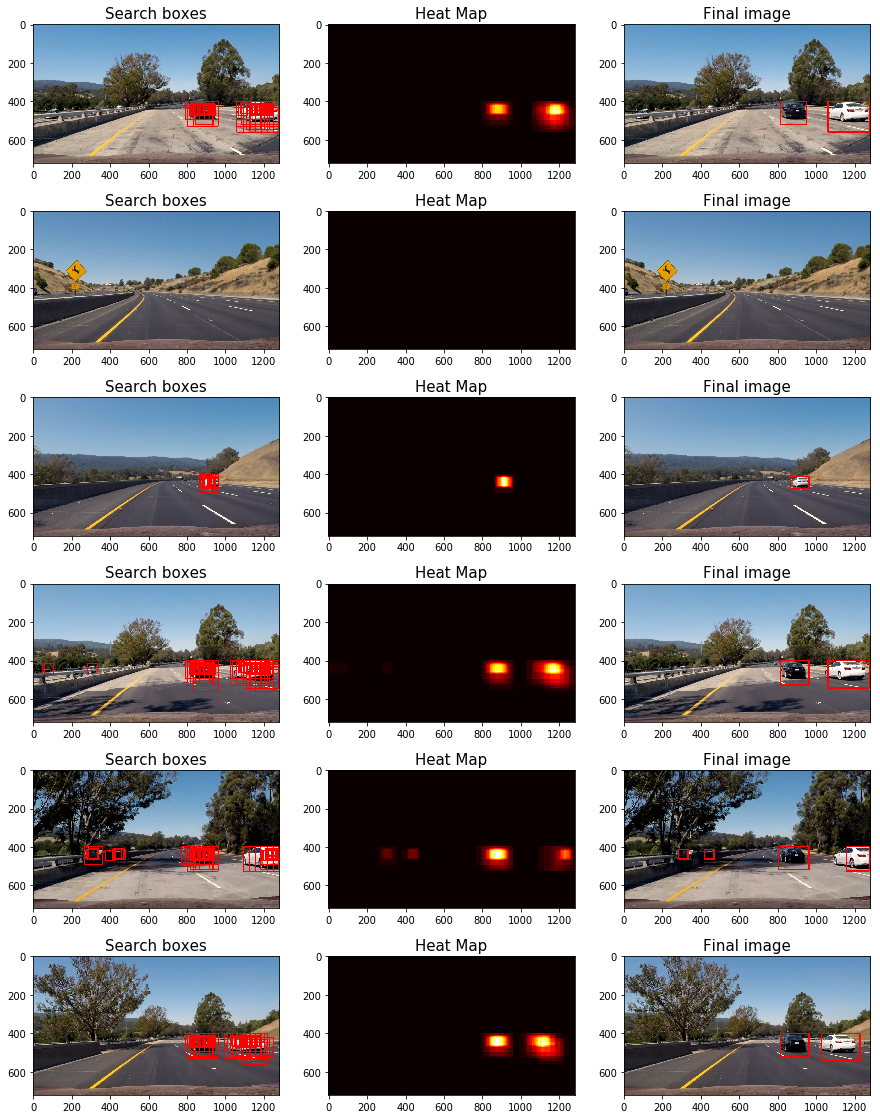

In [11]:
test_cars = glob.glob('./test_images/*.*')
image_num = len(test_cars)
fig=plt.figure(figsize=(15, 20))

for idx, test_car in enumerate(test_cars):
    # Read image
    img = mpimg.imread(test_car)
    boxes = []
    for scale, ystart, ystop, cells_per_step in zip(scales, ystarts, ystops, cps):
        boxes_each = find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, 
                              cell_per_block, spatial_size, hist_bins, cells_per_step)
        boxes.extend(boxes_each)
    
    fig.add_subplot(image_num, 3, idx*3+1)
    out_img = draw_boxes(img, boxes)
    plt.imshow(out_img)
    plt.title("Search boxes", fontsize=15)
    
    fig.add_subplot(image_num, 3, idx*3+2)
    heated=add_heat(img, boxes)
    plt.imshow(heated, cmap='hot')
    plt.title("Heat Map", fontsize=15)
    
    fig.add_subplot(image_num, 3, idx*3+3)
    heated_thres = apply_threshold(heated, 2)
    labels = label(heated_thres)
    final_image = draw_labeled_bboxes(np.copy(img), labels)
    plt.imshow(final_image)
    plt.title("Final image", fontsize=15)

### Building Pipeline

In [14]:
# Class for storing previous frames information
class vehicleTracker():
    def __init__(self):
        self.heatmap = []
        self.ave_heatmap = 0
        self.fheatmap = []

car = vehicleTracker()

def final_filter(ll):
    n = len(ll)
    out = np.copy(ll[0])
    s = np.shape(out)
    for i in range(n-1):
        for j in range(s[0]):
            for k in range(s[1]):
                out[j][k] = out[j][k] and ll[i+1][j][k]
    return out

def video_process(image):
    boxes = []
    # Get all scales boxes
    for scale, ystart, ystop, c in zip(scales, ystarts, ystops, cps):
        boxes_each = find_cars(image, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, 
                      cell_per_block, spatial_size, hist_bins, c)
        boxes.extend(boxes_each)

    out_img = draw_boxes(image, boxes)
    # find heated boxes
    heated = add_heat(image, boxes)
    heated_thres = apply_threshold(heated, 3)
 
    # store the heat map of current frame
    car.heatmap.append(heated_thres)
    # pop out very old one
    if len(car.heatmap) > 10:
        car.heatmap.pop(0)
    # filter
    heatmap_sum = np.sum(car.heatmap, axis=0)
    heatmap_final = apply_threshold(heatmap_sum, len(car.heatmap)*1)
    if len(car.heatmap) == 1:
        car.ave_heatmap = heatmap_final
    else:
        car.ave_heatmap = car.ave_heatmap*0.3 + heatmap_final*0.7/len(car.heatmap)
    
    h_final = apply_threshold(car.ave_heatmap, 2)
    car.fheatmap.append(h_final)
    if len(car.fheatmap) > 5:
        car.fheatmap.pop(0)
    
    out_heat = final_filter(car.fheatmap)
    labels = label(out_heat)
    final_image = draw_labeled_bboxes(np.copy(image), labels)
    
    return final_image


In [16]:
# video processing
output = './project_video_output.mp4'
clip = VideoFileClip("./project_video.mp4")
clip = clip.fl_image(video_process)
clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [54:31<00:02,  2.60s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

